In [1]:
%load_ext autoreload
%autoreload 2

from bosonicplus.optimizer import GBS_optimizer
from bosonicplus.cost_functions import symm_effective_squeezing_gradients, symm_effective_squeezing, state_prep_GBS, gkp_squeezing, gkp_squeezing_gradients
from bosonicplus.plotting import plot_wigner_marginals
from bosonicplus.effective_sqz import effective_sqz
from bosonicplus.conversions import dB_to_Delta, Delta_to_dB
import numpy as np
import matplotlib.pyplot as plt

## Optimising a GBS circuit

In [2]:
opt = GBS_optimizer(4,
                    pattern = [3,3,3], 
                    inf = 1e-4, 
                    bs_arrange='Clements',
                    gradients = True,
                    costf_lattice = 's',
                    costf = symm_effective_squeezing_gradients
                   )

np.random.seed(12)

opt.set_initial_guess()
print(opt.num_params)
print(opt.init_costf)

10
(1.0847137493686445, array([ 0.05894045,  0.94064925,  0.23556139,  0.61324769, -5.50879689,
       -3.21074897, -0.26397757, -3.61732308,  4.37809631, -4.15435919]))


In [3]:
opt.run_global_optimisation(niter = 30)
print(opt.result.fun)
print(opt.result)

basinhopping step 0: f 0.698422
basinhopping step 1: f 0.698422 trial_f 1.33857 accepted 0  lowest_f 0.698422
basinhopping step 2: f 1.3356 trial_f 1.3356 accepted 1  lowest_f 0.698422
basinhopping step 3: f 0.54915 trial_f 0.54915 accepted 1  lowest_f 0.54915
found new global minimum on step 3 with function value 0.54915
basinhopping step 4: f 0.532207 trial_f 0.532207 accepted 1  lowest_f 0.532207
found new global minimum on step 4 with function value 0.532207
basinhopping step 5: f 0.592995 trial_f 0.592995 accepted 1  lowest_f 0.532207
basinhopping step 6: f 0.552198 trial_f 0.552198 accepted 1  lowest_f 0.532207
basinhopping step 7: f 0.543774 trial_f 0.543774 accepted 1  lowest_f 0.532207
basinhopping step 8: f 0.54576 trial_f 0.54576 accepted 1  lowest_f 0.532207
basinhopping step 9: f 0.478433 trial_f 0.478433 accepted 1  lowest_f 0.478433
found new global minimum on step 9 with function value 0.478433
basinhopping step 10: f 0.47967 trial_f 0.47967 accepted 1  lowest_f 0.47843

Probability 0.0008290102027846921
Delta_x 0.45498655420481504
Delta_p 0.4095760541668805
symm Delta [dB] 7.284670938852717


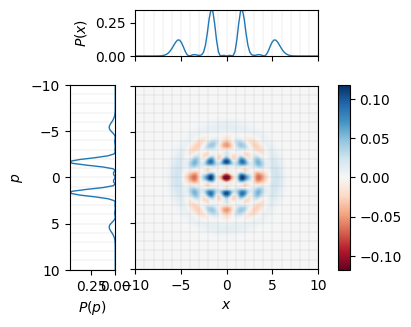

In [4]:
#Plot the output state

opt.set_initial_guess(params = opt.res_dict)

args = (opt.num_modes, 
        opt.pattern, 
        opt.bs_arrange, 
        opt.setting, 
        opt.etas, 
        opt.nbars, 
        opt.pPNR,  
        False, #no gradients
        opt.inf,
        True) #fast rep


out = state_prep_GBS(opt.result.x, *args)
print('Probability', out.norm)
out.reduce(np.sum(opt.pattern))
Dx = effective_sqz(out, 'sx')
Dp = effective_sqz(out, 'sp')
print('Delta_x', Dx)
print('Delta_p', Dp)
print('symm Delta [dB]', Delta_to_dB(0.5*(Dx+Dp)))
x = np.linspace(-10,10,100)
W = out.get_wigner_log(x,x)
plot_wigner_marginals(W.real,x,x)
plt.show()

## Other photon number patterns of optimal circuit


In [5]:
#check that the measurement probability sums to 1 of other patterns (up to a cutoff).
from itertools import product
prob = 0
cutoff = 12
patterns = list(product(range(cutoff), repeat=opt.num_modes-1))
print('pattern | norm | Delta_x | Delta_p')
for pattern in patterns: 
    
    args = (opt.result.x,
        opt.num_modes, 
        pattern, 
        opt.bs_arrange, 
        opt.setting, 
        opt.etas, 
        opt.nbars, 
        opt.pPNR, 
        False, #no gradients
        opt.inf, 
        True) #fast rep
    
    out = state_prep_GBS(*args)
    Delta_x=effective_sqz(out, 'sx')
    Delta_p=effective_sqz(out, 'sp')
    if Delta_x < 0.5 or Delta_p < 0.5:
        print(pattern, out.norm, Delta_x, Delta_p)
    
    if out.norm > 0:
        prob += out.norm
   

print('total prob', prob) 

pattern | norm | Delta_x | Delta_p
(1, 3, 4) 0.0006238523219057014 0.4481151228480133 0.6558397564969884
(1, 6, 3) 0.0008586438539667646 0.4951760386275805 0.6446256760490396
(2, 2, 3) 0.0008417487431076888 0.4991991585838858 1.377360140049991
(3, 2, 3) 0.00216686196784399 0.6929849947597908 0.4636337641234708
(3, 3, 3) 0.0008290102027846921 0.45741226727229034 0.4107416797546584
(3, 4, 8) 0.00013043105031737976 0.46577821508444395 0.530659751324084
(3, 5, 7) 7.253744260834874e-05 0.8430688544283206 0.4515682728166617
(4, 3, 2) 0.0009795876797647478 0.4928490670457632 0.5085847807794202
(4, 4, 0) 0.0005887642850699297 1.5450117744342813 0.48840392341435884
(4, 6, 5) 0.0002083907649955673 0.5518500549748444 0.4159357073275465
(4, 6, 9) 5.412242409281468e-05 0.4957774924675916 0.6412179257330053
(4, 8, 10) 1.584190983492105e-05 1.1185828185421873 0.4460008052597846
(6, 4, 8) 0.00011385230115356441 0.4823970436857351 1.0208085824029611
(6, 5, 8) 9.4578809167497e-05 0.47032656548872737 0.8

## Same optimisation, but without gradients

In [6]:
opt = GBS_optimizer(4, 
                    pattern = [3,3,3], 
                    inf = 1e-4, 
                    bs_arrange='Clements',
                    costf_lattice = 's',
                    costf = symm_effective_squeezing
                   )
np.random.seed(12)
opt.set_initial_guess()
print(opt.init_costf)

1.0847137647145606


In [7]:
opt.run_global_optimisation(niter = 30)
print(opt.result.fun)
print(opt.result)

basinhopping step 0: f 0.708068
basinhopping step 1: f 0.507253 trial_f 0.507253 accepted 1  lowest_f 0.507253
found new global minimum on step 1 with function value 0.507253
basinhopping step 2: f 0.74505 trial_f 0.74505 accepted 1  lowest_f 0.507253


/Users/s163967/Library/CloudStorage/OneDrive-DanmarksTekniskeUniversitet/Git_Repos/bosonicplus/src/bosonicplus/effective_sqz.py:61: RuntimeWarning: invalid value encountered in sqrt
  D1 = np.sqrt(-2/np.abs(alpha)**2*np.log(np.abs(f1)))
/Users/s163967/Library/CloudStorage/OneDrive-DanmarksTekniskeUniversitet/Git_Repos/bosonicplus/src/bosonicplus/effective_sqz.py:62: RuntimeWarning: invalid value encountered in sqrt
  D2 = np.sqrt(-2/np.abs(alpha)**2*np.log(np.abs(f2)))


basinhopping step 3: f 0.635898 trial_f 0.635898 accepted 1  lowest_f 0.507253
basinhopping step 4: f 0.510359 trial_f 0.510359 accepted 1  lowest_f 0.507253
basinhopping step 5: f 0.536001 trial_f 0.536001 accepted 1  lowest_f 0.507253
basinhopping step 6: f 0.536001 trial_f 0.602191 accepted 0  lowest_f 0.507253
basinhopping step 7: f 0.729223 trial_f 0.729223 accepted 1  lowest_f 0.507253
basinhopping step 8: f 0.729223 trial_f 0.966146 accepted 0  lowest_f 0.507253
basinhopping step 9: f 0.469842 trial_f 0.469842 accepted 1  lowest_f 0.469842
found new global minimum on step 9 with function value 0.469842
basinhopping step 10: f 0.636902 trial_f 0.636902 accepted 1  lowest_f 0.469842
basinhopping step 11: f 0.636902 trial_f 1.51469 accepted 0  lowest_f 0.469842
basinhopping step 12: f 0.527295 trial_f 0.527295 accepted 1  lowest_f 0.469842
basinhopping step 13: f 0.537009 trial_f 0.537009 accepted 1  lowest_f 0.469842
basinhopping step 14: f 0.764325 trial_f 0.764325 accepted 1  lo

Probability 0.00033857686233464346
Delta_x 0.6806022789568065
Delta_p 0.2346301302274088


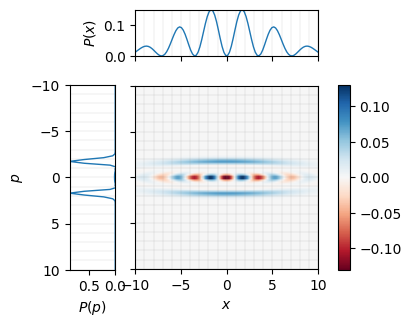

In [8]:
#Plot the output state

opt.set_initial_guess(params = opt.res_dict)

args = (opt.num_modes, 
        opt.pattern, 
        opt.bs_arrange, 
        opt.setting, 
        opt.etas, 
        opt.nbars, 
        opt.pPNR,  
        False, #no gradients
        opt.inf,
        True) #fast rep

out = state_prep_GBS(opt.result.x, *args)
print('Probability', out.norm)
out.reduce(np.sum(opt.pattern))
print('Delta_x', effective_sqz(out, 'sx'))
print('Delta_p', effective_sqz(out, 'sp'))
x = np.linspace(-10,10,100)
W = out.get_wigner_log(x,x)
plot_wigner_marginals(W.real,x,x)
plt.show()